# Introducing TimeLMs

TimeLMs allows for easy access to models continuously trained on social media over regular intervals for researching language model degradation, as well as cultural shifts affecting language usage on social media.

In this notebook we'll show to use TimeLMs for two tasks: masked prediction and computing perplexity scores.
We show how both tasks can be addressed using different modes:
- 'latest', using our most recently trained Twitter model.
- 'custom', using a model for a custom date provided by the user.
- 'corresponding', using the model that was trained only until to each tweet's date (i.e., its specific quarter).
- 'quarterly', using all available models trained over time in quarterly intervals.

Only the 'corresponding' mode requires the 'created_at' field.

## Getting Started

Before running this notebook, make sure you create a separate environment for TimeLMs and install dependencies.
You may create a new environment using conda and install dependencies following the commands below.
We assume you already have PyTorch with CUDA support installed (tested with torch==1.8.2+cu111 and CUDA 11.2).

Afterwards, make sure you're using running this notebook using the appropriate kernel.

```bash
$ conda create -n timelms python=3.7
$ conda activate timelms
$ pip install -r requirements.txt
```

Having setup your environment, you can start using TimeLMs as simply as shown below:

In [1]:
from timelms import TimeLMs
tlms = TimeLMs(device='cuda:0')

## Masked Predictions

Below we have tweets with a random word replaced with the model's mask token. You may experiment with other sentences or masking positions.

In [2]:
tweets = [{"text": "So glad I'm <mask> vaccinated .", "created_at": "2021-02-01T23:14:26.000Z"},
          {"text": "I keep forgetting to bring a <mask> .", "created_at": "2020-01-18T09:22:48.000Z"},
          {"text": "Looking forward to watching <mask> Game tonight !", "created_at": "2021-10-11T12:34:56.000Z"}]

In [3]:
def print_masked_predictions(preds):  # helper function for more readable outputs
    for tw in preds:
        print(tw['text'])
        for model_name in sorted(tw['predictions'].keys(), key=lambda x: tlms.model2date(x)):
            print('\t', model_name.split('-')[-1])
            for pred in tw['predictions'][model_name]:
                print('\t\t', round(pred['score'], 6), pred['token_str'])
        print()

In [4]:
preds = tlms.get_masked_predictions(tweets, mode='corresponding', top_k=3)

print_masked_predictions(preds)

So glad I'm <mask> vaccinated .
	 mar2021
		 0.506805  getting
		 0.256622  not
		 0.073613  fully

I keep forgetting to bring a <mask> .
	 mar2020
		 0.079254  bag
		 0.078195  purse
		 0.073761  charger

Looking forward to watching <mask> Game tonight !
	 dec2021
		 0.327614  Squid
		 0.258569  the
		 0.138299  The



In [5]:
preds = tlms.get_masked_predictions(tweets, mode='latest', top_k=3)

print_masked_predictions(preds)

So glad I'm <mask> vaccinated .
	 dec2021
		 0.327812  fully
		 0.266009  getting
		 0.253695  not

I keep forgetting to bring a <mask> .
	 dec2021
		 0.077349  bag
		 0.075191  lighter
		 0.065851  charger

Looking forward to watching <mask> Game tonight !
	 dec2021
		 0.327613  Squid
		 0.258569  the
		 0.138299  The



In [6]:
preds = tlms.get_masked_predictions(tweets, mode='2020-04', top_k=3)

print_masked_predictions(preds)

So glad I'm <mask> vaccinated .
	 jun2020
		 0.486295  not
		 0.235272  getting
		 0.072481  fully

I keep forgetting to bring a <mask> .
	 jun2020
		 0.075227  mask
		 0.064533  bag
		 0.05607  purse

Looking forward to watching <mask> Game tonight !
	 jun2020
		 0.318902  The
		 0.29253  the
		 0.219134  End



In [7]:
preds = tlms.get_masked_predictions(tweets, mode='quarterly', top_k=3)

print_masked_predictions(preds)

So glad I'm <mask> vaccinated .
	 mar2020
		 0.518831  not
		 0.172038  getting
		 0.10072  self
	 jun2020
		 0.486295  not
		 0.235272  getting
		 0.072481  fully
	 sep2020
		 0.541163  not
		 0.214932  getting
		 0.070767  fully
	 dec2020
		 0.386371  not
		 0.298721  getting
		 0.100641  fully
	 mar2021
		 0.506804  getting
		 0.256623  not
		 0.073613  fully
	 jun2021
		 0.466774  fully
		 0.270858  getting
		 0.149782  not
	 sep2021
		 0.380552  fully
		 0.330308  getting
		 0.148695  not
	 dec2021
		 0.327812  fully
		 0.266009  getting
		 0.253695  not

I keep forgetting to bring a <mask> .
	 mar2020
		 0.079254  bag
		 0.078195  purse
		 0.073761  charger
	 jun2020
		 0.075227  mask
		 0.064533  bag
		 0.05607  purse
	 sep2020
		 0.104582  mask
		 0.077254  bag
		 0.064505  purse
	 dec2020
		 0.10412  bag
		 0.095423  purse
		 0.071389  charger
	 mar2021
		 0.085629  purse
		 0.083771  charger
		 0.081422  bag
	 jun2021
		 0.096614  bag
		 0.064811  charger
		 0.055432  lighter

### Visualizing Masked Predictions

You can easily generate plots showing the distribution of top-k predictions for all models by following the steps below.

In [8]:
tweets = [{"text": "I keep forgetting to bring a <mask> ."}]
preds = tlms.get_masked_predictions(tweets, mode='quarterly', top_k=-1)  # get scores for entire vocabulary

In [9]:
import numpy as np

# get union of top 3 predictions from all models applied to tweet
top3_all_models = set()
for model_name, model_preds in preds[0]['predictions'].items():
    for p in model_preds[:3]:
        top3_all_models.add(p['token_str'])

# get scores from all models for that subset of tokens
subset_scores = {t:np.zeros(len(preds[0]['predictions'])) for t in top3_all_models}

for model_idx, (model_name, model_preds) in enumerate(preds[0]['predictions'].items()):
    for p in model_preds:
        if p['token_str'] in subset_scores:
            subset_scores[p['token_str']][model_idx] = p['score']

In [10]:
import pandas as pd
df = pd.DataFrame.from_dict(subset_scores)
df

,charger,purse,bag,lighter,mask
0,0.073761,0.078195,0.079254,0.043628,0.005185
1,0.055261,0.056070,0.064532,0.031794,0.075227
2,0.051945,0.064505,0.077254,0.041102,0.104582
3,0.071389,0.095423,0.104120,0.055308,0.041425
4,0.083771,0.085629,0.081422,0.057436,0.041936
5,0.064811,0.052290,0.096614,0.055432,0.033918
6,0.108284,0.064440,0.079544,0.059080,0.033827
7,0.065851,0.058379,0.077349,0.075191,0.026301


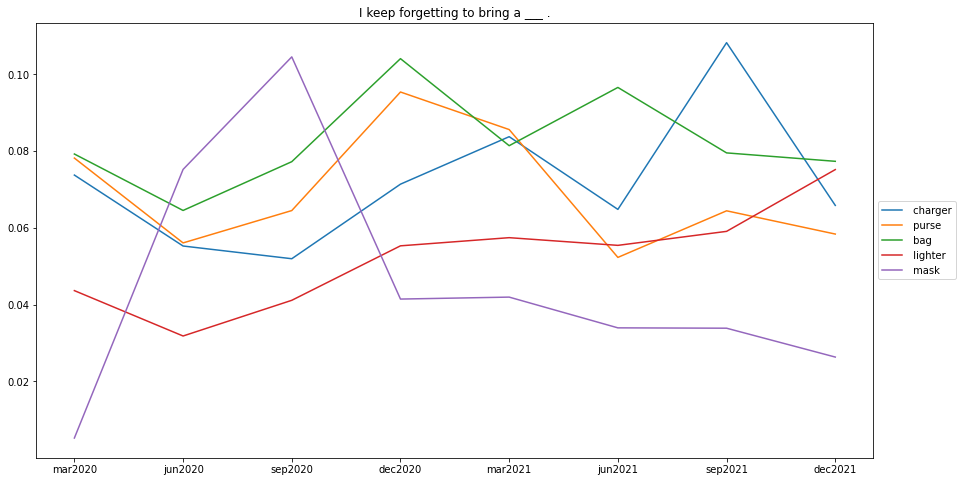

In [11]:
labels = [m.split('-')[-1] for m in preds[0]['predictions'].keys()]
a = df.plot(figsize=(15, 8), title=tweets[0]['text'].replace('<mask>', '___'))
a.set_xticks(df.index, labels)
a.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

## Perplexity Scores

Below we have tweets with associated dates (the 'created_at' field, following the Twitter API field name).

TimeLMs provides the Pseudo Perplexity (PPPL) score for a set of tweets, and the Pseudo Log Likelihood (PLL) score for individual tweets. If you want to compare the PLL score between different tweets, you should also use the number of subtokens for normalization, provided in the output. For more details about these scores, please see [Salazar et al 2020](https://arxiv.org/abs/1910.14659).

In [12]:
tweets = [{'text': 'She is pure heart #SanaTheBBWinner', 'created_at': '2020-02-09T05:55:00.000Z'},
          {'text': '@BoredApeYC @user is flipper3.0, Makes Dr. Burry feel like a boomer', 'created_at': '2021-11-11T23:10:00.000Z'},
          {'text': 'Looking forward to watching Squid Game tonight !', 'created_at': '2021-10-11T12:34:56.000Z'}]

In [13]:
def print_pppl(pseudo_ppls, tweets):  # helper function for more readable outputs

    print('Pseudo Perplexity Scores (PPPL) for set of tweets:')
    for model_name in pseudo_ppls:
        print(f"\t{model_name.split('-')[-1]}: {round(pseudo_ppls[model_name]['pppl'], 3)}")
    print()

    print('Pseudo Log-Likelihood (PLL) by tweet:')
    for tw in tweets:
        print('\nTweet:', tw['text'])
        for model_name in sorted(tw['scores'].keys(), key=lambda x: tlms.model2date(x)):
            print(f"\t{model_name.split('-')[-1]}: {round(tw['scores'][model_name], 3)}")
        print()

In [14]:
pseudo_ppls = tlms.get_pseudo_ppl(tweets, mode='corresponding')

print_pppl(pseudo_ppls, tweets)

Pseudo Perplexity Scores (PPPL) for set of tweets:
	mar2020: 3.347
	dec2021: 5.664

Pseudo Log-Likelihood (PLL) by tweet:

Tweet: She is pure heart #SanaTheBBWinner
	mar2020: -14.496


Tweet: @BoredApeYC @user is flipper3.0, Makes Dr. Burry feel like a boomer
	dec2021: -53.601


Tweet: Looking forward to watching Squid Game tonight !
	dec2021: -10.561



In [15]:
pseudo_ppls = tlms.get_pseudo_ppl(tweets, mode='latest')

print_pppl(pseudo_ppls, tweets)

Pseudo Perplexity Scores (PPPL) for set of tweets:
	dec2021: 5.803

Pseudo Log-Likelihood (PLL) by tweet:

Tweet: She is pure heart #SanaTheBBWinner
	dec2021: -22.0


Tweet: @BoredApeYC @user is flipper3.0, Makes Dr. Burry feel like a boomer
	dec2021: -53.601


Tweet: Looking forward to watching Squid Game tonight !
	dec2021: -10.561



In [16]:
pseudo_ppls = tlms.get_pseudo_ppl(tweets, mode='quarterly')

print_pppl(pseudo_ppls, tweets)

Pseudo Perplexity Scores (PPPL) for set of tweets:
	mar2020: 18.762
	jun2020: 20.022
	sep2020: 20.506
	dec2020: 19.295
	mar2021: 19.473
	jun2021: 14.636
	sep2021: 8.346
	dec2021: 5.803

Pseudo Log-Likelihood (PLL) by tweet:

Tweet: She is pure heart #SanaTheBBWinner
	mar2020: -14.496
	jun2020: -18.785
	sep2020: -20.087
	dec2020: -17.557
	mar2021: -19.363
	jun2021: -21.44
	sep2021: -22.217
	dec2021: -22.0


Tweet: @BoredApeYC @user is flipper3.0, Makes Dr. Burry feel like a boomer
	mar2020: -92.476
	jun2020: -91.488
	sep2020: -91.245
	dec2020: -90.408
	mar2021: -89.938
	jun2021: -74.091
	sep2021: -55.696
	dec2021: -53.601


Tweet: Looking forward to watching Squid Game tonight !
	mar2020: -36.686
	jun2020: -36.571
	sep2020: -36.683
	dec2020: -37.067
	mar2021: -36.181
	jun2021: -35.961
	sep2021: -26.057
	dec2021: -10.561

